In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch

In [0]:
import torch.nn as nn
import torch.optim as optims
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

In [95]:
# loading datasets
train_dataset = dsets.CIFAR10(root='./data', train = True, transform=transforms.ToTensor(), download = True)
test_dataset = dsets.CIFAR10(root='./data', train =  False, transform = transforms.ToTensor(), download  = True)

Files already downloaded and verified
Files already downloaded and verified


In [96]:
len(train_dataset), len(test_dataset), train_dataset[0][0].size(), train_dataset[0][1]

(50000, 10000, torch.Size([3, 32, 32]), 6)

In [97]:
CLASSES =('plane','car','bird','cat','deer','dog', 'frog', 'horse','ship','truck')
CLASSES[train_dataset[0][1]]

'frog'

In [98]:
cuda = torch.cuda.is_available()
print(cuda)

torch.manual_seed(10)
if cuda:
  torch.cuda.manual_seed(10)

#defining batch size and iterations
batch_size = 100
n_iter = 6000
num_epochs = n_iter/ (len(train_dataset)/batch_size)
num_epochs = int(num_epochs)


#loading dataset
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader =  torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

True


In [0]:
#define a model
class CNNModel(nn.Module):
  def __init__(self, pool='nn.MaxPool2d'):
    super(CNNModel,self).__init__()
    
    #convolution1
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size = 5, stride=1, padding = 0)
    self.relu1 = nn.ReLU()
    #pooling1
    self.pooling1 = pool(kernel_size=2)
    
    #convolution2
    self.cnn2 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size = 5, stride = 1, padding = 0)
    self.relu2 = nn.ReLU()
    #pooling2
    self.pooling2 = pool(kernel_size = 2)
    
    #Fully connected1
    self.fc1 = nn.Linear(32*5*5,10)
    
  def forward(self,x):
    # x = torch.size([100,3,32,32])
    #convultion1
    out = self.cnn1(x) # torch.size([100,20,28,28])
    #plt.imshow(out.view(out.size(0),-1).data.cpu().numpy())
    #plt.show()
    out = self.relu1(out)# torch.size([100,20,28,28])
    
    #pooling1
    out = self.pooling1(out)# torch.size([100,20,14,14])
    
    #convultion2
    out = self.cnn2(out)# torch.size([100,32,10,10])
    out = self.relu2(out)# torch.size([100,32,10,10])
    
    #pooling2
    out = self.pooling2(out)# torch.size([100,32,5,5])
    
    out = out.view(out.size(0),-1)# torch.size([100,512])
    
    #Fully connected1
    out = self.fc1(out)# torch.size([100,10])
    
    return out
  
  def image_output(self,x):
    #convultion1
    cnn_out1 = self.cnn1(x) #torch.size([100,20,28,28])
    cnn_out2 = self.relu1(cnn_out1) #torch.size([100,20,28,28])
    cnn_out2 = self.pooling1(cnn_out2) #torch.size([100,20,14,14])
    
    #convultion2
    cnn_out2 = self.cnn2(cnn_out2) #torch.size([100,32,10,10])
    
    return cnn_out1,cnn_out2
    
  

In [100]:
#train the model
num_epochs = 15
pooling = [nn.MaxPool2d, nn.AvgPool2d]
for pool in pooling:
  iter = 0
  print('Pool:',pool)
  #instantiate model class
  model = CNNModel(pool)
  if cuda:
    model.cuda()
  #instantiate loss class
  criterion = nn.CrossEntropyLoss()
  
  #instantiate optimizer class
  learning_rate = 0.01
  optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate)

  for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
      if cuda:
        images = Variable(images.cuda())
        labels = Variable(labels.cuda())
      else:
        images = Variable(images)
        labels = Variable(labels)
    
      #clear gradients wrt parameters
      optimizer.zero_grad()
    
      #forward pass to get outputs/labels
      outputs = model(images)
    
      #calculate loss(cross entropy loss)
      loss = criterion(outputs, labels)
    
      #getting gradient wrt parameters
      loss.backward()
    
      #update parameters
      optimizer.step()
    
      iter+=1
    
      if iter%500 == 0:
        #calculate accuracy
        correct = 0
        total = 0
        #iterate through test dataset
        for images, labels in test_loader:
          if cuda:
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())
          else:
            images =Variable(images)
            labels =Variable(labels)
         
          #forward pass only to get logits/labels
          outputs = model(images)
        
          #get predictions from the maximum value
          _,predicted = torch.max(outputs.data,1)
        
          #total no. of labels
          total += len(labels)
        
          #correct outputs
          if cuda:
            correct += (predicted.cpu() == labels.cpu()).sum()
          else:
            correct += (predicted == labels).sum()
          
        accuracy = 100 * correct/total
        
        # Print Loss
        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.data[0], accuracy))

Pool: <class 'torch.nn.modules.pooling.MaxPool2d'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 500. Loss: 2.0133142471313477. Accuracy: 25
Iteration: 1000. Loss: 1.7470784187316895. Accuracy: 33
Iteration: 1500. Loss: 1.5927211046218872. Accuracy: 39
Iteration: 2000. Loss: 1.612288475036621. Accuracy: 42
Iteration: 2500. Loss: 1.553725004196167. Accuracy: 44
Iteration: 3000. Loss: 1.6858104467391968. Accuracy: 46
Iteration: 3500. Loss: 1.4371238946914673. Accuracy: 46
Iteration: 4000. Loss: 1.601284384727478. Accuracy: 49
Iteration: 4500. Loss: 1.5159457921981812. Accuracy: 51
Iteration: 5000. Loss: 1.2856237888336182. Accuracy: 51
Iteration: 5500. Loss: 1.2609624862670898. Accuracy: 52
Iteration: 6000. Loss: 1.3542852401733398. Accuracy: 52
Iteration: 6500. Loss: 1.295739769935608. Accuracy: 54
Iteration: 7000. Loss: 1.158381700515747. Accuracy: 54
Iteration: 7500. Loss: 1.0844053030014038. Accuracy: 53
Pool: <class 'torch.nn.modules.pooling.AvgPool2d'>
Iteration: 500. Loss: 2.1538548469543457. Accuracy: 23
Iteration: 1000. Loss: 1.9840470552444458. Accuracy: 31
Iter

In [0]:
def visualise_kernel(kernel,num_kernels):
  #num_kernels = kernel.shape[0]
  num_cols = 8
  num_rows = 1+num_kernels
  fig = plt.figure(figsize = (num_cols,num_rows))
  for i in range(num_kernels):
    ax1 = fig.add_subplot(num_rows,num_cols,i+1)
    ax1.imshow(kernel[i],cmap = 'gray')
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])

1st  & 2nd Convolution Layer Outputs
Filters Visualisation


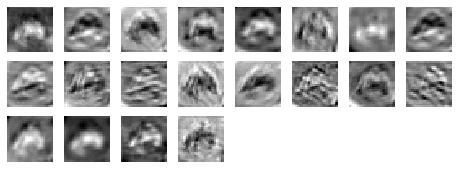

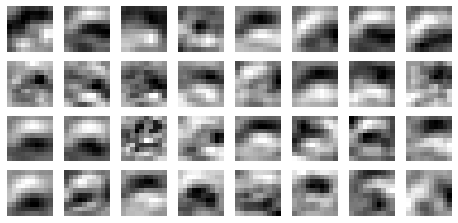

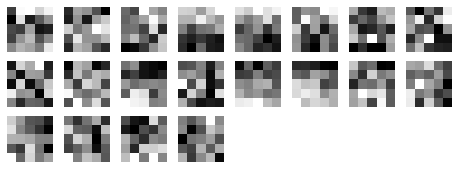

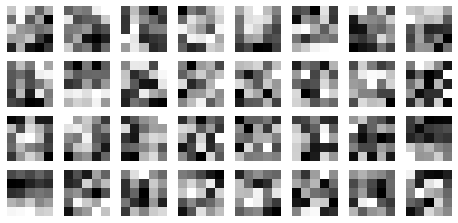

In [102]:
#CNN visualisation layer output
'''Taking an image from train dataset
and applying the CNN model on it'''
(images,labels) = train_dataset[0]
images = images.view(1,3,32,32).cuda()
cnn_out1,cnn_out2 = model.image_output(images)
cnn_out1,cnn_out2 = cnn_out1.view(20,28,28),cnn_out2.view(32,10,10)

print('1st  & 2nd Convolution Layer Outputs')
cnn_out1 = cnn_out1.data.cpu().numpy()
visualise_kernel(cnn_out1,cnn_out1.shape[0])

cnn_out2 = cnn_out2.data.cpu().numpy()
visualise_kernel(cnn_out2,cnn_out2.shape[0])


#Filters visualisation
filters = model.modules()
model_layers = [i for i in model.children()]
first_layer = model_layers[0]
second_layer = model_layers[3]
print('Filters Visualisation')

first_kernels = first_layer.weight.data.cpu().numpy()
first_kernels = first_kernels.reshape(60,5,5)
visualise_kernel(first_kernels,20)
second_kernels = second_layer.weight.data.cpu().numpy()
second_kernels = second_kernels.reshape(640,5,5)
visualise_kernel(second_kernels,32)